In [59]:
from jaxgym.ode import odedopri,  electron_equation_of_motion_DA
from jaxgym.field import schiske_lens_expansion_xyz, obtain_first_order_electrostatic_lens_properties
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp
import numpy as np
import optimistix as optx

from scipy.constants import h as h_planck, e, m_e
from daceypy import array, DA
import sympy as sp
import os

from scipy.integrate import simpson
from tqdm import tqdm
import matplotlib.pyplot as plt

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


%matplotlib widget

In [60]:
X, Y, Z = sp.symbols('X Y Z')

scale = 1 #set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.015*scale  # Convert m to um units
a = 0.0004*scale  # Convert m to um units
phi_0 = 10000  # Volts

k = 0.4**(1/2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda, phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck/(2*abs(e)*m_e*phi_lambda_axial(z_init))**(1/2)*scale


z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = obtain_first_order_electrostatic_lens_properties(
    z_init, phi_lambda_axial, phi_lambda_prime, phi_lambda_double_prime, z_sampling=1000)

In [ ]:
z_init = jnp.array(z_init)
z_image = jnp.array(z_image)

PointSource = comp.InputPlane(z=z_init)
ElectrostaticLens = comp.ODE(z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda)
Detector = comp.Detector(z=z_image, det_pixel_size=(5e-9 * scale, 5e-9 * scale), det_shape = (128, 128))
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

In [62]:
ray = Ray(0., 0., 0., 0., 0., z_init, 0.0)
ray_out = run_to_end(ray, model)

order = 4
derivatives = calculate_derivatives(ray, model, order)

In [63]:
selected_vars = ['x', 'y', 'dx', 'dy', 'pathlength']
multi_indices = order_indices(order, n_vars=len(selected_vars))

poly_dicts = poly_dict(derivatives, selected_vars, multi_indices[1:])

x_var, y_var, dx_var, dy_var, x_out, y_out, dx_out, dy_out, opl_var = sp.symbols("x y x' y' x_out y_out dx_out, dy_out S", real=True)
x_a, y_a = sp.symbols("x_a y_a", real=True)
polynomials = poly_dict_to_sympy_expr(poly_dicts, selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var])
polynomials['pathlength'] = polynomials['pathlength'].subs({opl_var: 0})

In [64]:
jax_poly_x = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['x'], modules='jax')
jax_poly_y = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['y'], modules='jax')
jax_poly_dx = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['dx'], modules='jax')
jax_poly_dy = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['dy'], modules='jax')
jax_poly_opl = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['pathlength'], modules='jax')

## Create amplitude evaluation function ##
dSdxodxp = sp.diff(polynomials['pathlength'], x_var, dx_var)
dSdxodyp = sp.diff(polynomials['pathlength'], x_var, dy_var)
dSdyodxp = sp.diff(polynomials['pathlength'], y_var, dx_var)
dSdyodyp = sp.diff(polynomials['pathlength'], y_var, dy_var)
jacobian = sp.Matrix([[dSdxodxp, dSdxodyp], [dSdyodxp, dSdyodyp]])

amplitude = sp.lambdify(
    [x_var, y_var, dx_var, dy_var],
    1/(1j * wavelength * sp.sqrt(jacobian.det())),
    modules='jax'
)

In [65]:
from functools import partial
@partial(jax.jit, static_argnames=['num_x', 'num_y'])
def simpson2d(f, ax, bx, ay, by, num_x, num_y):
  """
  Evaluate a 2D integral using Simpson's rule for potentially different
  numbers of points in the x and y dimensions.

  Parameters:
    f (ndarray): 1D array of ravelled 2D function values.
    ax, bx (float): Integration bounds for x.
    ay, by (float): Integration bounds for y.
    num_x (int): Number of points in x dimension.
    num_y (int): Number of points in y dimension.

  Returns:
    float: Approximate value of the integral.
  """
  hx = (bx - ax) / (num_x - 1)
  hy = (by - ay) / (num_y - 1)

  idx_x = jax.lax.iota(jnp.int32, num_x)
  wx = 4 - 2 * (idx_x % 2)
  wx = wx.at[0].set(1)
  wx = wx.at[-1].set(1)
  
  idx_y = jax.lax.iota(jnp.int32, num_y)
  wy = 4 - 2 * (idx_y % 2)
  wy = wy.at[0].set(1)
  wy = wy.at[-1].set(1)

  # Construct the 2D weight matrix as an outer product.
  weights = jnp.outer(wx, wy).ravel()
  
  # Multiply by hx*hy/9 based on Simpson's rule in two dimensions.
  return hx * hy / 9 * jnp.sum(f * weights)


In [66]:
sample_object = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
sample_object = sample_object[1:-1, 1:-1]  # Crop the image to remove borders
sample_shape = sample_object.shape

object_x = jnp.linspace(-1e-7, 1e-7, sample_shape[0])
object_y = jnp.linspace(-1e-7, 1e-7, sample_shape[1])
object_x, object_y = jnp.meshgrid(object_x, object_y)
object_x = object_x.ravel()
object_y = object_y.ravel()

x_det_shape, y_det_shape = Detector.det_shape

# flatten detector coordinates
x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()


@jax.jit
def solve_slopes(x_input, y_input, x_det_pixel, y_det_pixel):
    
    # Find the slope of the ray in the input plane that will land on the desired detector pixel
    def input_slope_from_image_position_loss(params, args):
        dx, dy = params
        x_in, y_in, x_out, y_out = args
        res_x = jax_poly_x(x_in, y_in, dx, dy) - x_out 
        res_y = jax_poly_y(x_in, y_in, dx, dy) - y_out

        return res_x, res_y

    slope_in_x, slope_in_y = optx.root_find(
        input_slope_from_image_position_loss,
        optx.Newton(rtol=1e-14, atol=1e-14),
        jnp.array([0., 0.]), # initial guess for slopes
        (x_input, y_input, x_det_pixel, y_det_pixel)
    ).value
    
    return slope_in_x, slope_in_y

solve_slopes_vmap = jax.vmap(solve_slopes, in_axes=(None, None, 0, 0))

def compute_wave(x_input, y_input):
    dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)
    opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)

    phase = (2*jnp.pi*(opl/wavelength) + jnp.pi) % (2*jnp.pi) - jnp.pi
    amp = amplitude(x_input, y_input, dx_input, dy_input)

    kernel = jnp.exp(1j*phase) * amp
    return kernel

dx = Detector.det_pixel_size[0]
dy = Detector.det_pixel_size[1]

def compute_integral(U, x_input, y_input):
    wave_detector = compute_wave(x_input, y_input)
    out = wave_detector * U * dx * dy

    return out

Uobject = jnp.ravel(sample_object)
Uobject = jnp.array(Uobject, dtype=jnp.complex128)
Uobject = jnp.abs(Uobject) * jnp.exp(1j * jnp.abs(Uobject))

compute_integral_batch = jax.jit(jax.vmap(compute_integral, 
                                          in_axes=(0, 0, 0)))

batch_size = 500  # number of pixels per batch
num_pixels = Uobject.shape[0]
output = jnp.zeros(len(x_det), dtype=jnp.complex128)

for i in tqdm(range(0, num_pixels, batch_size), leave=True):
    U_batch = Uobject[i:i+batch_size]
    x_batch = object_x[i:i+batch_size]
    y_batch = object_y[i:i+batch_size]
    
    det_wave_batch = compute_integral_batch(
        U_batch,                   # Input Object Wavefunction
        x_batch,                   # Object x-coordinates
        y_batch,                   # Object y-coordinates
    )
    output += det_wave_batch.sum(axis=0)

output = output.reshape((x_det_shape, y_det_shape))

  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


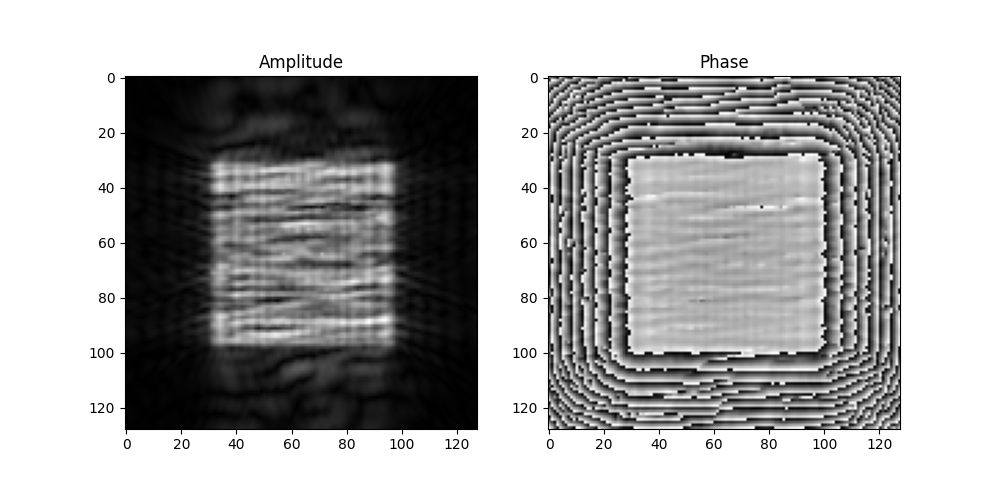

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(output), cmap='gray')
ax[0].set_title('Amplitude')
ax[1].imshow(np.angle(output), cmap='gray')
ax[1].set_title('Phase')
plt.show()


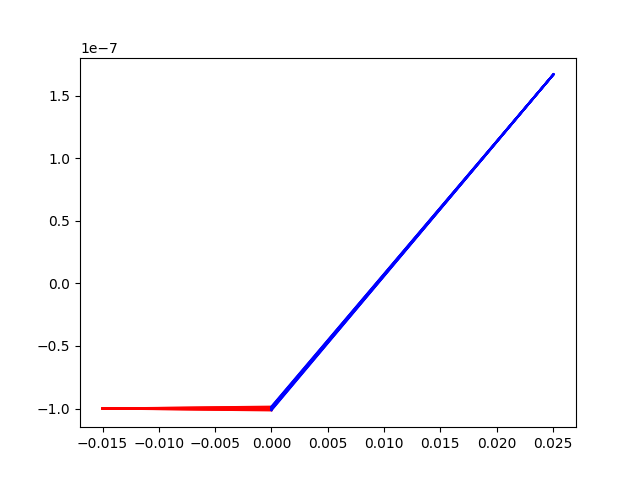

In [100]:
n_rays = 10
input_rays_x = jnp.linspace(-1e-7, -1e-7, n_rays)
input_rays_y = jnp.linspace(-1e-7, -1e-7, n_rays)
dx_input = jnp.linspace(-1e-7, 1e-7, n_rays)
dy_input = jnp.linspace(-1e-7, 1e-7, n_rays)

output_rays_x = jax_poly_x(input_rays_x, input_rays_y, dx_input, dy_input)
output_rays_y = jax_poly_y(input_rays_x, input_rays_y, dx_input, dy_input)
output_rays_dx = jax_poly_dx(input_rays_x, input_rays_y, dx_input, dy_input)
output_rays_dy = jax_poly_dy(input_rays_x, input_rays_y, dx_input, dy_input)

z_input_aperture = 0.0

input_aperture_rays_x = input_rays_x + dx_input * abs(z_init)
input_aperture_rays_y = input_rays_y + dy_input * abs(z_init)

output_aperture_rays_x = output_rays_x + output_rays_dx * -z_image
output_aperture_rays_y = output_rays_y + output_rays_dy * -z_image


plt.figure()
plt.plot([z_init, z_input_aperture], [input_rays_x[:n_rays], input_aperture_rays_x[:n_rays]], 'r-')
plt.plot([z_input_aperture, z_image], [output_aperture_rays_x[:n_rays], output_rays_x[:n_rays]], 'b-')


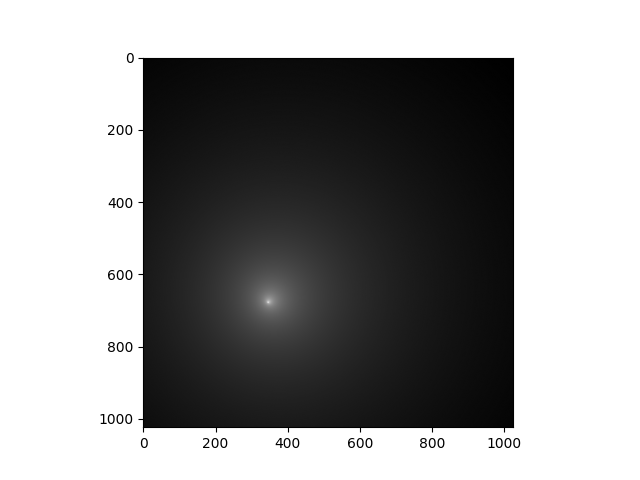

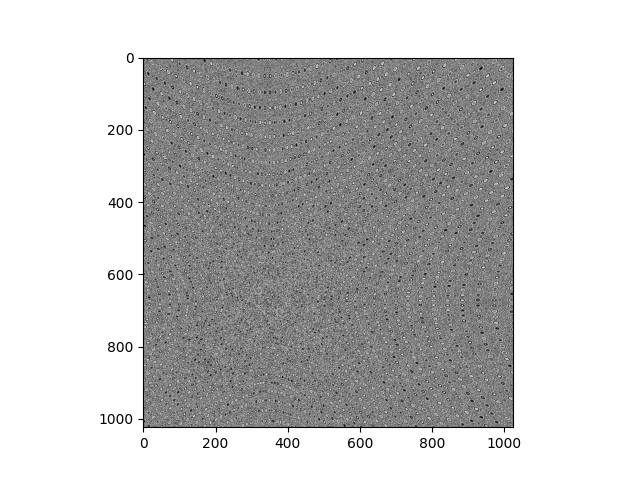

In [105]:
z_input_aperture = 0.0
z_output_aperture = 0.0

Detector = comp.Detector(z=z_image, det_pixel_size=(1e-7, 1e-7), det_shape = (1024, 1024))
det_coords = Detector.get_coords()
n_rays = Detector.det_shape[0]
x_det_shape, y_det_shape = Detector.det_shape
x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()
x_input, y_input = 1e-5, 1e-5
dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)

output_rays_x = jax_poly_x(x_input, y_input, dx_input, dy_input)
output_rays_y = jax_poly_y(x_input, y_input, dx_input, dy_input)
output_rays_dx = jax_poly_dx(x_input, y_input, dx_input, dy_input)
output_rays_dy = jax_poly_dy(x_input, y_input, dx_input, dy_input)

amp = amplitude(x_input, y_input, dx_input, dy_input)
opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)
phase = (2*jnp.pi*(opl/wavelength) + jnp.pi) % (2*jnp.pi) - jnp.pi
phase = phase.reshape((x_det_shape, y_det_shape))
amp = amp.reshape((x_det_shape, y_det_shape))

wave = jnp.exp(1j*phase) * amp * dx * dy

plt.figure()
plt.imshow(jnp.log(np.abs(wave)), cmap='gray')
plt.show()

plt.figure()
plt.imshow(np.angle(wave), cmap='gray')
plt.show()
